In [2]:
import pandas as pd
import datetime as dt
import quandl
import math
import numpy as np 
from sklearn import preprocessing, model_selection, svm #cross_validation is now model_selection
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt    
from matplotlib import style 
import pickle
style.use('ggplot') 


In [7]:
#Setting up dataframe
df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_pct'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.00
#Low minus high divided by open, for pct change
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.00

df = df[['Adj. Close', 'HL_pct', 'PCT_change', 'Adj. Volume']]
print(df.head())

Adj. Close    HL_pct  PCT_change  Adj. Volume
Date                                                     
2004-08-19   50.322842  3.712563    0.324968   44659000.0
2004-08-20   54.322689  0.710922    7.227007   22834300.0
2004-08-23   54.869377  3.729433   -1.227880   18256100.0
2004-08-24   52.597363  6.417469   -5.726357   15247300.0
2004-08-25   53.164113  1.886792    1.183658    9188600.0


In [8]:
#col for forecasts
forecast_col = 'Adj. Close'
#fill missing data, to be treated as outlier
df.fillna(-99999, inplace=True)
#Will try and predict out 1% of df
forecast_out = int(math.ceil(0.01*len(df)))

#Shift columns negatively, will shift cols up the df.
#Label col for each row will be adj close price from the future 1% ahead. About 30 days with current dataset
df['label'] = df[forecast_col].shift(-forecast_out)

In [9]:
####
#X for features, y for label

X = np.array(df.drop(['label'], 1)) 
X = preprocessing.scale(X)
X_recent = X[-forecast_out:] #Do not have a y-val for these
X = X[:-forecast_out:]

df.dropna(inplace=True)
y = np.array(df['label'])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

clf = LinearRegression(n_jobs=-1) #Run 10 jobs at a time, use -1 uses as many jobs as possible by processor
clf.fit(X_train, y_train) #training

#pickle to save
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f) #dumps classifier to f

pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

accuracy = clf.score(X_test, y_test) #for test score accuracy
print(accuracy)


0.977825934707491


[1103.73961341 1072.01906897 1019.06091116 1061.3619583  1072.83900726
 1073.25871657 1092.26629618 1111.07356212 1114.39802155 1122.78500256
 1132.13512142 1128.86145459 1148.49137974 1164.18432853 1135.31488874
 1121.73974551 1087.38019479 1103.69454862 1114.47044003 1120.71801039
 1135.31640132 1149.62813254 1181.35078952 1185.45018608 1157.09402042
 1168.40462078 1170.21395428 1152.5300115  1117.91723435 1114.58431048
 1112.73283559 1069.43928991 1042.23295524 1072.67042952 1020.5015517 ] 0.977825934707491 35


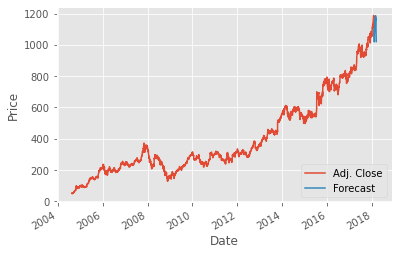

In [10]:
#Predictions
forecast_set = clf.predict(X_recent)
print(forecast_set, accuracy, forecast_out)

df['Forecast'] = np.nan

last_date = df.iloc[-1].name #Very last date
last_unix = last_date.timestamp()
one_day = 86400 #for unix time
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = dt.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    #takes all first cols, sets to nan for future data we don't have, sets final column to i
    df.loc[next_date] = [np.nan for x in range(len(df.columns)-1) ] + [i] #remember that df.loc references index

df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()